# Assignment for practical work 4. Basics of neural networks

Group:

*  Jannik Bucher
*  Dennis Imhof

### Using dataset: Page Blocks Dataset
[Page Blocks Dataset](https://archive.ics.uci.edu/ml/datasets/Page+Blocks+Classification)

## General Assignment

Before performing the practical work, you need download the data set accordingly to the option on your machine
1. Write a program that splits the original sample into a training set and a test set (training set, validation set, test set)
2. Build a model using Perceptron (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) and MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). On the basis of experiments, select values for learning rate, the regularization parameter, the optimization function.
3. Build learning curves for better explanation of your experiments.

## Options
Data sets are taken from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/
The option is determined by the data set, which can be downloaded from the link above:
The option is determined by the data set, which can be downloaded from the link above:
1. Sponge
2. Water Treatment Plant
3. Synthetic Control Chart Time Series
4. Character Trajectories
5. Plants
6. Libras Movement
7. KEGG Metabolic Relation Network (Directed)
8. SMS Spam Collection
9. seeds
10. Human Activity Recognition Using Smartphones
11. User Knowledge Modeling
12. NYSK
13. Activities of Daily Living (ADLs) Recognition Using Binary Sensors
14. Dresses_Attribute_Sales
15. Wholesale customers
16. StoneFlakes
17. Gesture Phase Segmentation
18. AAAI 2014 Accepted Papers
19. Dow Jones Index
20. AAAI 2013 Accepted Papers
21. wiki4HE
22. Folio
23. Mice Protein Expression
24. Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(9,9))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=3, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    best_test_param = param_range[np.argmax(test_scores_mean)]
    best_train_param = param_range[np.argmax(train_scores_mean)]

    best_test_score = np.max(test_scores_mean)
    best_train_score = np.max(train_scores_mean)
    
    
    plt.figure(figsize=(9,9))
    plt.title("Validation Curve {}: {} vs {}\nBest train param: {} - score: {}\nBest test param: {} - score {}".format(title, 
                                                                                                                       scoring, 
                                                                                                                       param_name, 
                                                                                                                       best_train_param, 
                                                                                                                       best_train_score, 
                                                                                                                       best_test_param,
                                                                                                                       best_test_score))
    plt.xlabel("{}".format(param_name))
    plt.ylabel("{}".format(scoring))
    #plt.ylim(0.1, 0.4)
    plt.axvline(best_test_param, color='darkorange', linestyle='--', label="best train param")
    plt.axvline(best_train_param, color='navy', linestyle='--', label="best test param")
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Page-Blocks dataset

In [4]:
elements = []
with open('data/page-blocks.data') as f:
    for l in f:       
        elements.append([float(x) for x in l.split()])
        
elements = np.array(elements)

In [5]:
columns = ['height', 
           'lenght', 
           'area',
           'eccen',
           'p_black',
           'p_and',
           'mean_tr',
           'blackpix',
           'blackand',
           'wb_trans',
           'block']

In [171]:
df = pd.DataFrame(elements, columns=columns)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("block", axis=1), df["block"], train_size=0.7, random_state=42)

In [173]:
X_train.describe()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000
mean,10.168102,88.115636,1182.607935,13.197051,0.367214,0.785362,6.415409,354.974158,725.282172,105.078831
std,14.038977,114.094530,4999.354600,29.384528,0.176054,0.170014,81.630229,1302.946891,1912.952788,162.250784
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000
25%,7.000000,17.000000,112.000000,2.111000,0.261000,0.680500,1.610000,42.000000,94.000000,17.000000
50%,8.000000,40.000000,320.000000,5.111000,0.337000,0.804000,2.070000,105.000000,246.000000,48.000000
75%,10.000000,104.000000,960.000000,13.309500,0.424000,0.925000,2.990000,278.000000,698.500000,123.000000
max,311.000000,553.000000,143993.000000,413.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000


## Normalizing the data

In [174]:
scale = StandardScaler()

In [175]:
X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scale.fit_transform(X_test), columns=X_test.columns)

### Building a MLPClassifier with Keras

In [176]:
from keras import models
from keras import layers
from keras import utils

In [177]:
y_train_oh = utils.np_utils.to_categorical(y_train)

In [178]:
model = models.Sequential()

In [179]:
model.add(layers.Dense(200, activation='relu', input_dim=10))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [180]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [181]:
hist = model.fit(X_train_scaled, y_train_oh, epochs=320, workers=-1, batch_size=128)

Epoch 1/320
3831/3831 [==============================] - 1s 324us/step - loss: 0.7003 - acc: 0.8815
Epoch 2/320
3831/3831 [==============================] - 0s 68us/step - loss: 0.2298 - acc: 0.9441
Epoch 3/320
3831/3831 [==============================] - 0s 70us/step - loss: 0.1559 - acc: 0.9488
Epoch 4/320
3831/3831 [==============================] - 0s 66us/step - loss: 0.1206 - acc: 0.9661
Epoch 5/320
3831/3831 [==============================] - 0s 69us/step - loss: 0.1094 - acc: 0.9668
Epoch 6/320
3831/3831 [==============================] - 0s 67us/step - loss: 0.0993 - acc: 0.9697
Epoch 7/320
3831/3831 [==============================] - 0s 70us/step - loss: 0.0901 - acc: 0.9721
Epoch 8/320
3831/3831 [==============================] - 0s 65us/step - loss: 0.0880 - acc: 0.9734
Epoch 9/320
3831/3831 [==============================] - 0s 63us/step - loss: 0.0868 - acc: 0.9713
Epoch 10/320
3831/3831 [==============================] - 0s 69us/step - loss: 0.0850 - acc: 0.9731
Epoch 11

In [182]:
pred_keras = model.predict_classes(X_test_scaled)

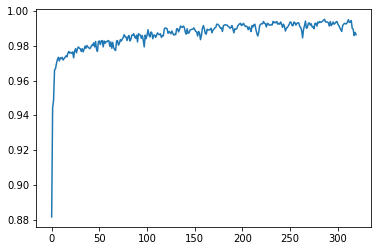

In [183]:
plt.plot(hist.epoch, hist.history['acc'])

In [184]:
pred_keras = model.predict_classes(X_test_scaled)

In [185]:
pred_train = model.predict_classes(X_train_scaled)

In [186]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         1.0       1.00      0.99      1.00      3447
         2.0       0.94      0.99      0.96       223
         3.0       0.84      0.89      0.86        18
         4.0       0.94      0.89      0.92        57
         5.0       0.85      0.99      0.91        86

    accuracy                           0.99      3831
   macro avg       0.91      0.95      0.93      3831
weighted avg       0.99      0.99      0.99      3831

